## Week 6 Homework

---

### Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random

In [ ]:
def log_joint_posterior(data, theta, var, nu, theta0, var0):
    """
    Computes the unnormalized joint posterior:
    p(theta, var, nu | x) ∝ p(x | theta, var, nu) * p(theta) * p(var) * p(nu)
    """
    n = len(data)
    if (var <= 0):
        return -np.inf
    else:
        log_likelihood = np.sum(stats.t.logpdf(data, nu, theta, np.sqrt(var)))
        log_prior_theta = stats.norm.logpdf(theta, loc=theta0, scale=np.sqrt(var0))
        log_prior_var = stats.halfnorm.logpdf(var, loc=0, scale=np.sqrt(var0))
        log_prior_nu = np.log(stats.randint.pmf(nu, 1, 101))
        return log_likelihood + log_prior_theta + log_prior_var + log_prior_nu

def metropolis_within_gibbs(data, theta0, var0, prop_sd_theta, prop_sd_var, burn_in, n_iter=5000):
    """
    Metropolis-within-Gibbs sampling for Normal(mean=theta, variance=var)
    """
    data = np.asarray(data)

    # Storage
    theta_samples = np.zeros(n_iter)
    var_samples = np.zeros(n_iter)
    nu_samples = np.zeros(n_iter)

    # Initialize parameters
    var_current = stats.halfnorm.rvs(scale=np.sqrt(var0))
    theta_current = np.random.normal(loc=theta0, scale=np.sqrt(var0))
    nu_current = np.random.randint(1, 101)

    # Track acceptance rates for tuning
    theta_acceptances = 0
    var_acceptances = 0
    nu_acceptances = 0

    for t in range(n_iter):
        # Step 1: Metropolis update for theta
        theta_proposed = np.random.normal(theta_current, prop_sd_theta)  # Scalar

        log_p_current_theta = log_joint_posterior(data, theta_current, var_current, nu_current, theta0, var0)
        log_p_proposed_theta = log_joint_posterior(data, theta_proposed, var_current, nu_current, theta0, var0)

        log_acceptance_ratio_theta = log_p_proposed_theta - log_p_current_theta
        if np.random.rand() < min(1, np.exp(log_acceptance_ratio_theta)):
            theta_current = theta_proposed  # Accept
            theta_acceptances += 1

        # Step 2: Metropolis update for var
        var_proposed = np.exp(np.random.normal(np.log(var_current), prop_sd_var))  # Log-normal proposal for positive var

        log_p_current_var = log_joint_posterior(data, theta_current, var_current, nu_current, theta0, var0)
        log_p_proposed_var = log_joint_posterior(data, theta_current, var_proposed, nu_current, theta0, var0)

        log_acceptance_ratio_var = log_p_proposed_var - log_p_current_var + \
            stats.halfnorm.logpdf(var_current, loc=0, scale=np.sqrt(var0)) - \
            stats.halfnorm.logpdf(var_proposed, loc=0, scale=np.sqrt(var0))

        if np.random.rand() < min(1, np.exp(log_acceptance_ratio_var)):
            var_current = var_proposed  # Accept
            var_acceptances += 1

        # Step 3: Metropolis update for nu
        nu_proposed = np.random.randint(1, 101)  # Propose new nu from discrete uniform

        log_p_current_nu = log_joint_posterior(data, theta_current, var_current, nu_current, theta0, var0)
        log_p_proposed_nu = log_joint_posterior(data, theta_current, var_current, nu_proposed, theta0, var0)

        log_acceptance_ratio_nu = log_p_proposed_nu - log_p_current_nu
        if np.random.rand() < min(1, np.exp(log_acceptance_ratio_nu)):
            nu_current = nu_proposed  # Accept
            nu_acceptances += 1

        theta_samples[t] = theta_current
        var_samples[t] = var_current
        nu_samples[t] = nu_current

    print(f"Theta AC Rate: {theta_acceptances / n_iter * 100:.2f}%")
    print(f"Variance AC Rate: {var_acceptances / n_iter * 100:.2f}%")
    print(f"Nu AC Rate: {nu_acceptances / n_iter * 100:.2f}%")

    # Discard burn-in
    return theta_samples[burn_in:], var_samples[burn_in:]

In [ ]:
np.random.seed(1)

# Generate synthetic data from Normal(mean = 5, var = 1)
true_theta = 10
true_var = 3
data = np.random.normal(true_theta, np.sqrt(true_var), size=100)

# Set prior hyperparameters
theta0 = 3  # Uninformative prior mean
var0 = 100    # Uninformative prior variance
prop_sd_theta = 0.5
prop_sd_var = 0.5


# Run the sampler
theta_samples, var_samples = metropolis_within_gibbs(
    data, theta0, var0, prop_sd_theta, prop_sd_var, burn_in = 400
)

Theta acceptance rate: 35.30%
Variance acceptance rate: 33.58%
Nu acceptance rate: 83.12%


In [ ]:
print("Posterior mean of theta:", np.mean(theta_samples))
print("Posterior mean of var:", np.mean(var_samples))
print("Mean of data:", np.mean(data))
print("Variance of data:", np.std(data)**2)

Posterior mean of theta: 10.053897725567072
Posterior mean of var: 0.7705773321322616
Mean of data: 10.060582852075699
Variance of data: 0.7835015228846669


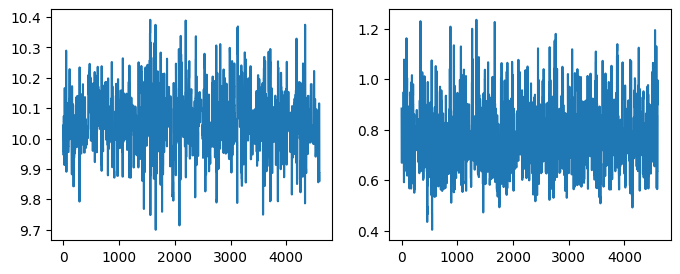

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(theta_samples)
ax[1].plot(var_samples)

In [ ]:
np.quantile(theta_samples, [0.025, 0.975])

array([ 9.86352231, 10.2518167 ])

In [ ]:
np.quantile(var_samples, [0.025, 0.975])

array([4.98301738, 9.2641676 ])

### Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*


Output()


Results for sample size n = 50:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta   9.577   0.221   9.162    9.994      0.001    0.001   38817.0   
var     2.320   0.517   1.425    3.287      0.003    0.002   35101.0   
nu     57.265  26.167  15.000  100.000      0.290    0.205    8060.0   

       ess_tail  r_hat  
theta   28084.0    1.0  
var     26314.0    1.0  
nu       8787.0    1.0  


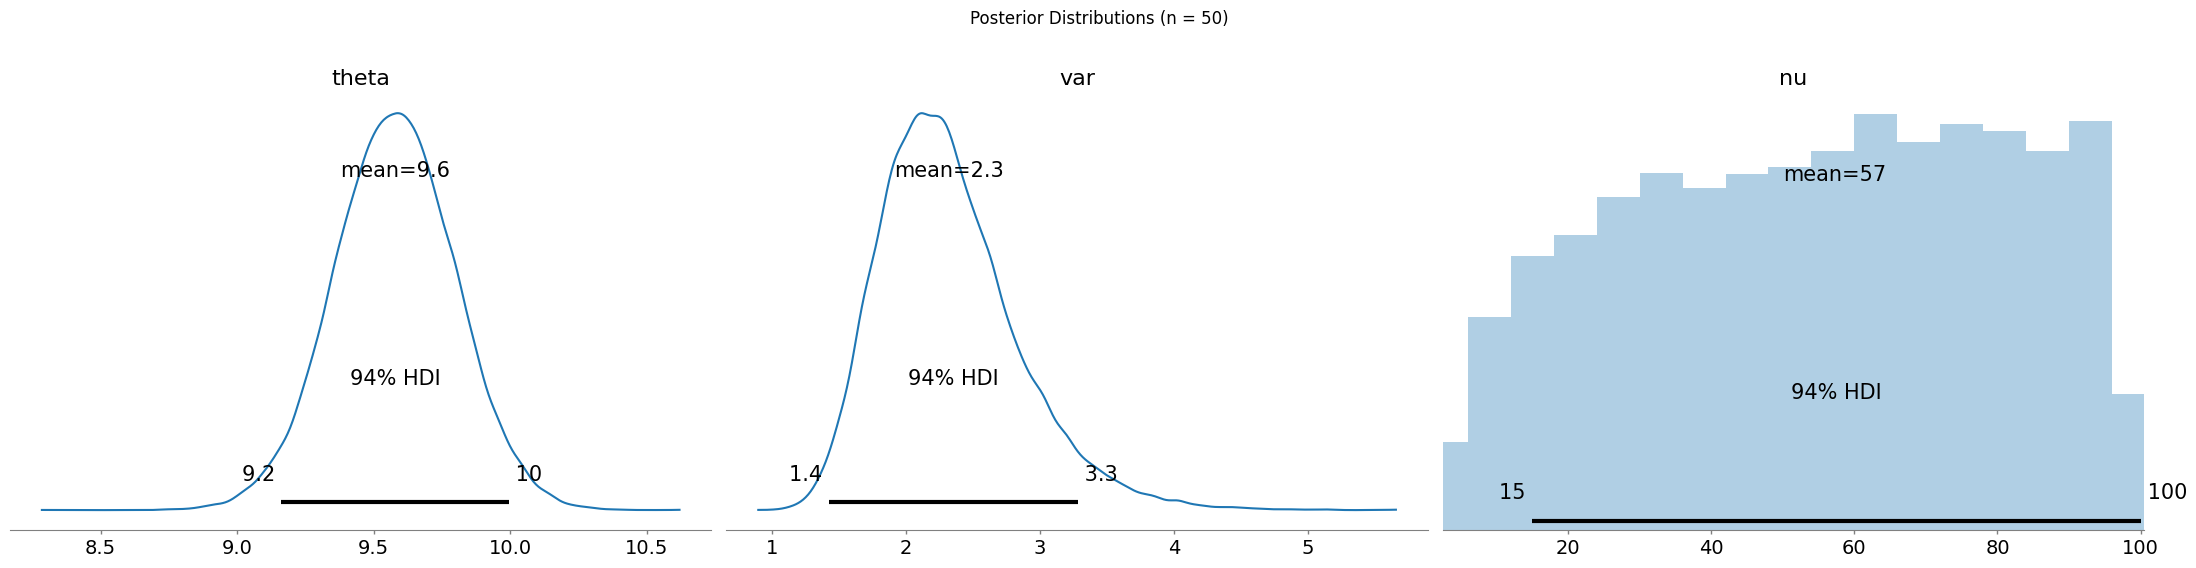

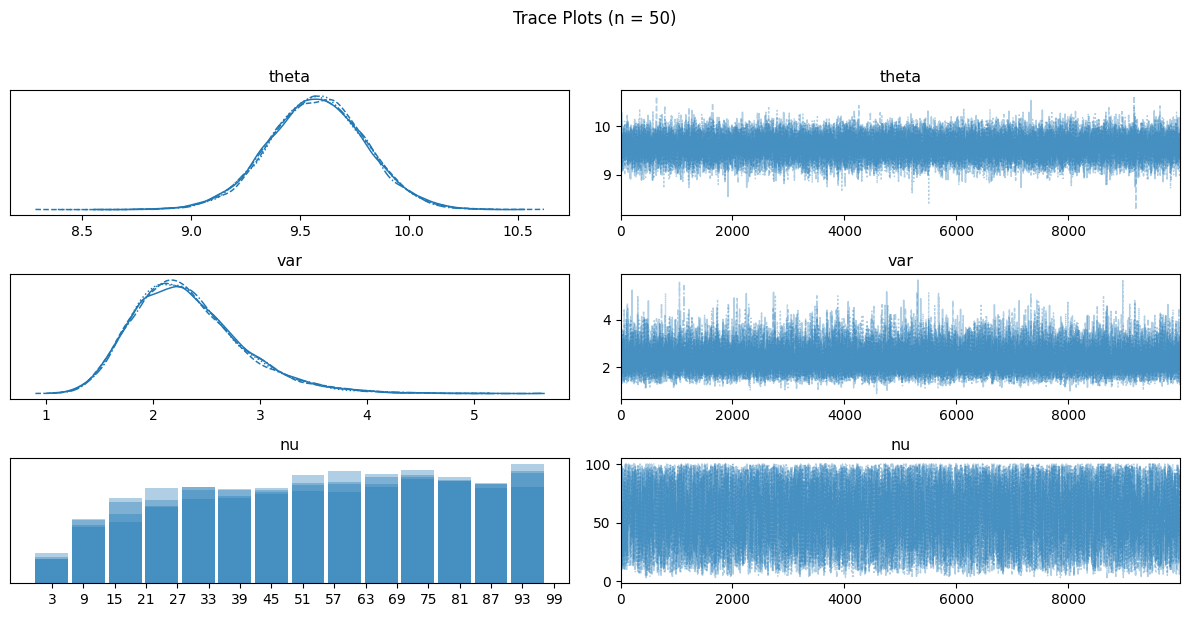

Output()


Results for sample size n = 100:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta  10.465   0.189  10.109   10.818      0.001    0.001   40631.0   
var     3.434   0.515   2.523    4.411      0.003    0.002   36418.0   
nu     62.065  24.139  22.000  100.000      0.286    0.202    7094.0   

       ess_tail  r_hat  
theta   28415.0    1.0  
var     29398.0    1.0  
nu       8504.0    1.0  


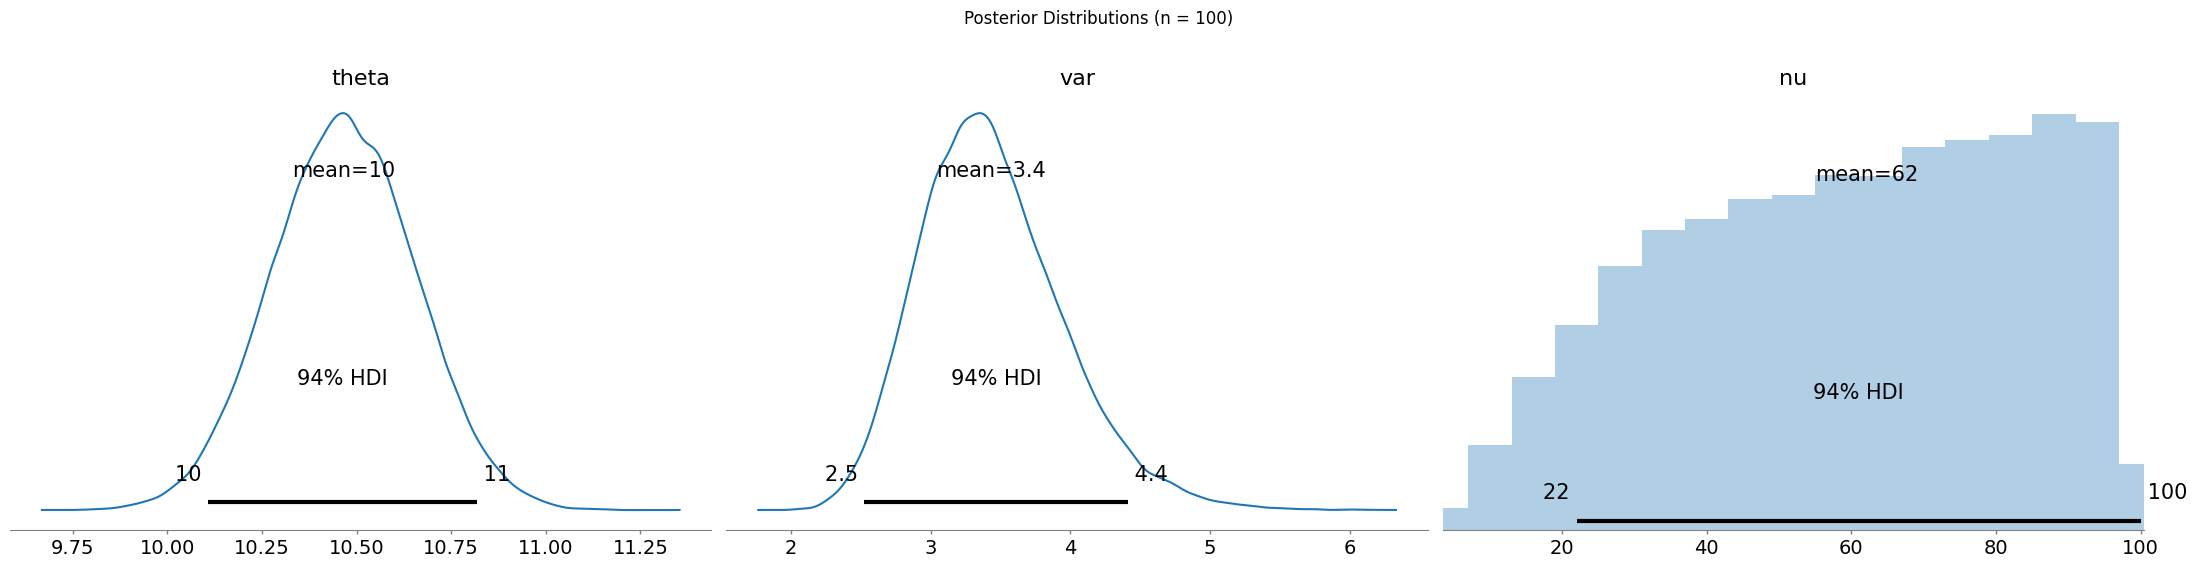

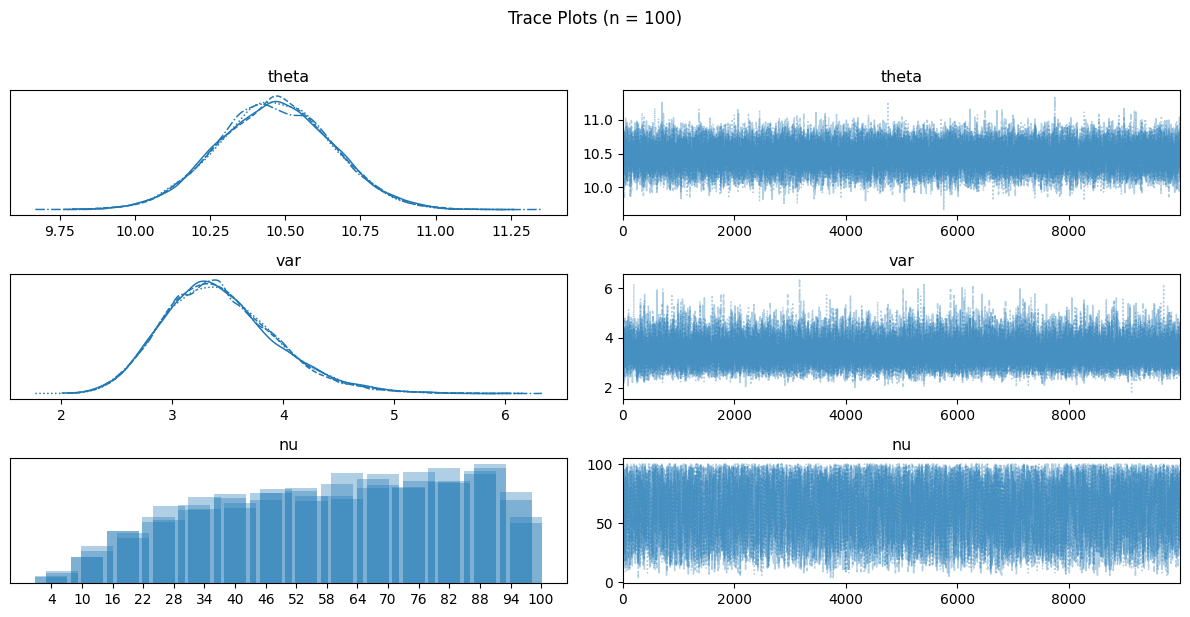

Output()


Results for sample size n = 500:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta   9.919   0.075   9.778   10.059      0.000    0.000   40975.0   
var     2.714   0.182   2.377    3.061      0.001    0.001   31700.0   
nu     65.503  22.327  28.000  100.000      0.255    0.180    7619.0   

       ess_tail  r_hat  
theta   28626.0    1.0  
var     26184.0    1.0  
nu       8200.0    1.0  


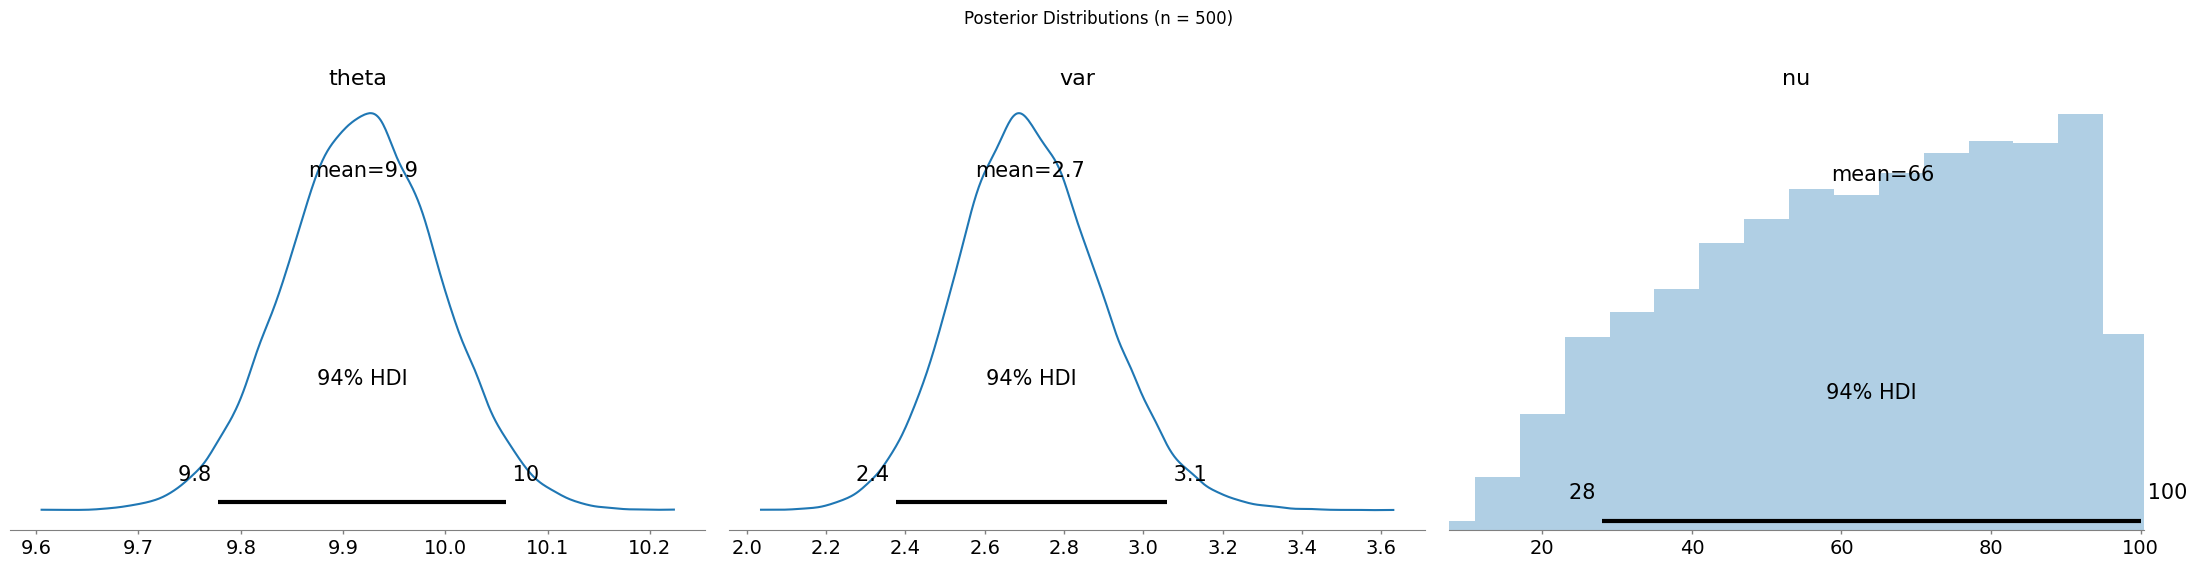

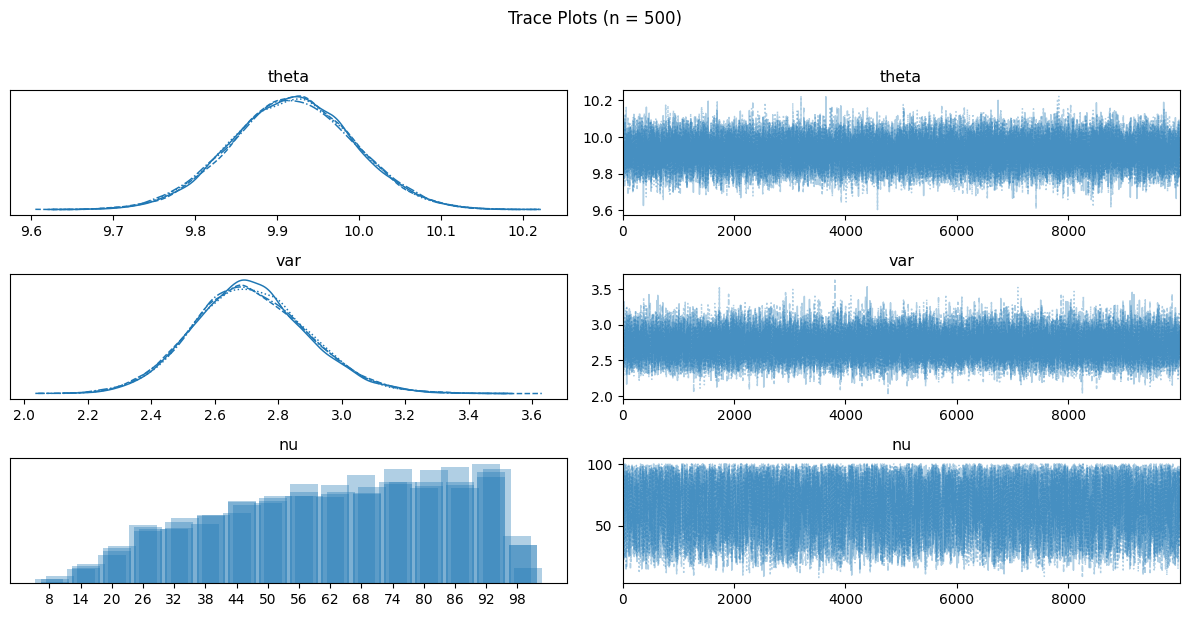

Output()


Results for sample size n = 1000:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta  10.009   0.053   9.911   10.110      0.000    0.000   40010.0   
var     2.776   0.132   2.530    3.023      0.001    0.001   27323.0   
nu     69.571  20.504  34.000  100.000      0.250    0.177    6693.0   

       ess_tail  r_hat  
theta   29065.0    1.0  
var     25921.0    1.0  
nu       8142.0    1.0  


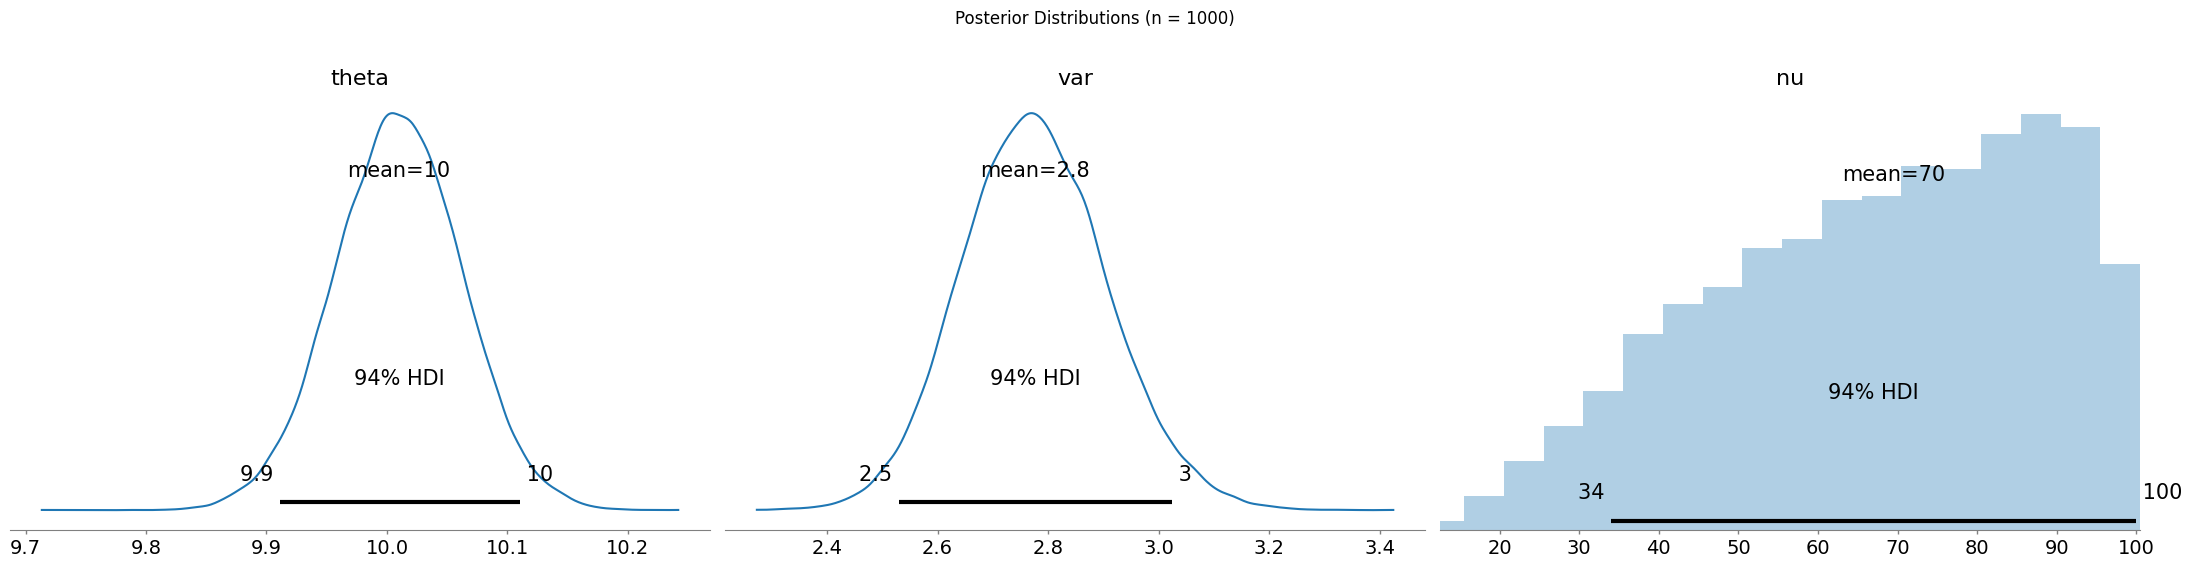

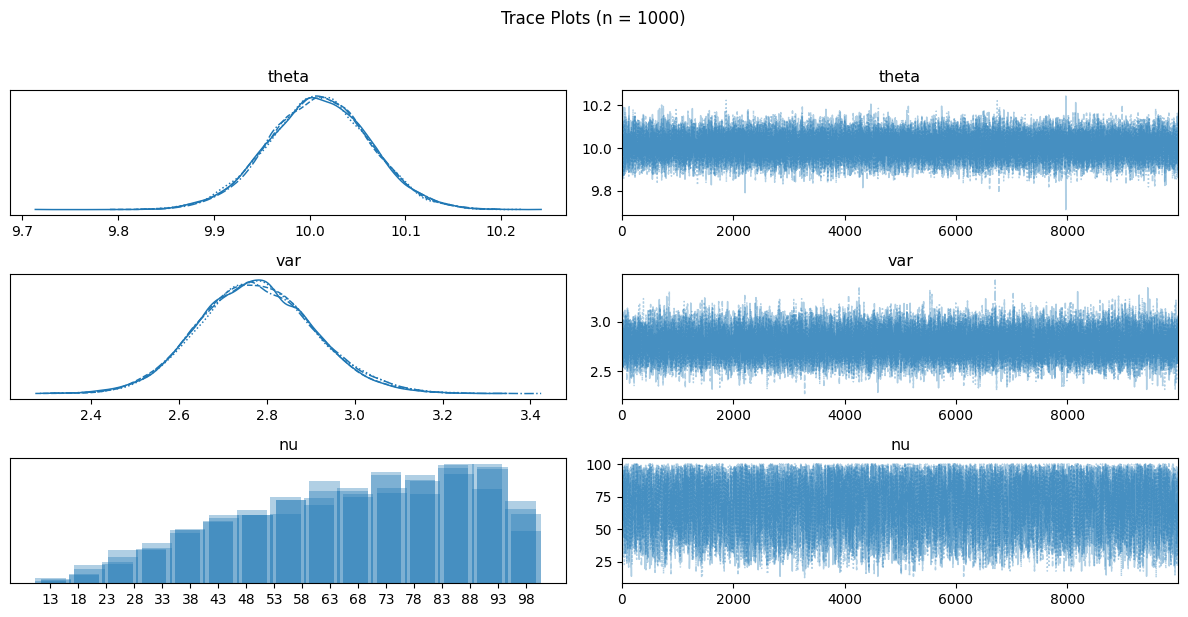

In [ ]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# True parameters for data generation.
true_theta = 10     # True mean
true_var = 3        # True variance

sample_sizes = [50, 100, 500, 1000]

# Dictionary to store the resulting InferenceData objects for each sample size.
results = {}

# Loop over different sample sizes.
for n in sample_sizes:
    # Generate synthetic data from a Normal distribution with mean = 50 and variance = 9.
    data = np.random.normal(true_theta, np.sqrt(true_var), size=n)

    # Define the PyMC model.
    with pm.Model() as model:
        theta = pm.Normal("theta", mu=0, sigma=np.sqrt(100))
        var = pm.HalfNormal("var", sigma=np.sqrt(100))
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)
        sigma = pm.Deterministic("sigma", pm.math.sqrt(var))
        obs = pm.StudentT("obs", nu=nu, mu=theta, sigma=sigma, observed=data)

        idata = pm.sample(chains=4, tune=2000, draws=10000, return_inferencedata=True)

    # Store the resulting InferenceData object in the dictionary.
    results[f"n={n}"] = idata

    print(f"\nResults for sample size n = {n}:")
    summary = az.summary(idata, var_names=["theta", "var", "nu"])
    print(summary)

    # Plot Posterior Distributions for theta, var, and nu.
    az.plot_posterior(idata, var_names=["theta", "var", "nu"])
    plt.suptitle(f"Posterior Distributions (n = {n})", y=1.02)
    plt.tight_layout()
    plt.show()

    # Plot Trace Plots to Check Convergence.
    az.plot_trace(idata, var_names=["theta", "var", "nu"])
    plt.suptitle(f"Trace Plots (n = {n})", y=1.02)
    plt.tight_layout()
    plt.show()


**Summary of Findings**

Altogether it appears all chains converged and mixed nicely. As sample size increases, the data provide stronger evidence about the distribution’s tail behavior. Since the true data are nearly normal or light-tailed, the likelihood will favor larger values of $\nu$, and with more data, the posterior for
$\nu$ will concentrate on these higher values. This is why we observe that the estimated $\nu$ increases with larger sample sizes. Larger sample sizes yield more precise, so narrower, posteriors for the degrees of freedom $\nu$ , reducing uncertainty. Conversely, with small n , the data are less informative, and the posterior for $\nu$ remains wide, reflecting high uncertainty. In practice, if one needs to estimate $\nu$ (to characterize the tail-heaviness of thedata), we must ensure that the dataset is large enough. Otherwise, inference for $\nu$ may be unstable, and credible intervals will be wide, making it difficult to draw strong conclusions about the tail behavior.

### Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$



We start with the following hierarchical model:

1. **Conditional on $\tau_i$:**  
   $
   y_i \mid \tau_i \sim \text{N}\Bigl(0,\,\tau_i^{-1}\Bigr)
   \quad\Longrightarrow\quad
   p(y_i \mid \tau_i) = \sqrt{\frac{\tau_i}{2\pi}} \exp\Bigl(-\frac{\tau_i\,y_i^2}{2}\Bigr).
   $

2. **Prior on $\tau_i$:**  
   $
   \tau_i \sim \textrm{Gamma}\Bigl(\alpha=\frac{\nu}{2},\,\beta=\frac{\nu}{2}\Bigr),
   $
   so
   $
   p(\tau_i) = \frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma\left(\frac{\nu}{2}\right)}\,\tau_i^{\frac{\nu}{2}-1} \exp\Bigl(-\frac{\nu}{2}\tau_i\Bigr).
   $

---

### Joint Expression

We need to compute the marginal density for $y_i$ by integrating out $\tau_i$:

$
\begin{aligned}
p(y_i) &= \int_0^\infty p(y_i\mid \tau_i)\,p(\tau_i)\,d\tau_i\\[1mm]
&=\int_0^\infty \sqrt{\frac{\tau_i}{2\pi}}\,\exp\!\Bigl(-\frac{\tau_i\,y_i^2}{2}\Bigr)
\frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma\left(\frac{\nu}{2}\right)}\,\tau_i^{\frac{\nu}{2}-1}\exp\!\Bigl(-\frac{\nu}{2}\tau_i\Bigr)d\tau_i.
\end{aligned}
$


1. **Combine the powers of $\tau_i$:**

   $
   \sqrt{\frac{\tau_i}{2\pi}} = \frac{1}{\sqrt{2\pi}}\,\tau_i^{1/2},
   $
   
   so together with \(\tau_i^{\frac{\nu}{2}-1}\) we have
   $
   \tau_i^{\frac{1}{2}+\frac{\nu}{2}-1} = \tau_i^{\frac{\nu+1}{2}-1}.
   $

2. **Combine the exponentials:**

   $
   \exp\!\Bigl(-\frac{\tau_i\,y_i^2}{2}\Bigr) \cdot \exp\!\Bigl(-\frac{\nu}{2}\tau_i\Bigr)
   = \exp\!\Bigl(-\frac{\tau_i}{2}(y_i^2+\nu)\Bigr).
   $

Thus, the integrand becomes

$
\frac{1}{\sqrt{2\pi}}\,\frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma\left(\frac{\nu}{2}\right)}\,\tau_i^{\frac{\nu+1}{2}-1} \exp\!\Bigl(-\frac{\tau_i}{2}(y_i^2+\nu)\Bigr).
$

So

$
p(y_i) = \frac{1}{\sqrt{2\pi}}\,\frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma\left(\frac{\nu}{2}\right)}
\int_0^\infty \tau_i^{\frac{\nu+1}{2}-1} \exp\!\Bigl(-\frac{\tau_i}{2}(y_i^2+\nu)\Bigr)d\tau_i.
$

---

### Recognize the Gamma Integral

Recall that for a Gamma density with shape $a$ and rate $b$, the normalization is given by:

$
\int_0^\infty \tau^{a-1}\exp(-b\,\tau)d\tau = \frac{\Gamma(a)}{b^a}.
$

Here we identify:

- $a = \frac{\nu+1}{2}$,
- $b = \frac{1}{2}(y_i^2+\nu)$.

Thus, the integral is

$
\int_0^\infty \tau_i^{\frac{\nu+1}{2}-1} \exp\!\Bigl(-\frac{\tau_i}{2}(y_i^2+\nu)\Bigr)d\tau_i
=\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\left(\frac{1}{2}(y_i^2+\nu)\right)^{\frac{\nu+1}{2}}}.
$

Plugging this back in, we obtain

$
p(y_i) = \frac{1}{\sqrt{2\pi}}\,\frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma\left(\frac{\nu}{2}\right)}
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\left(\frac{1}{2}(y_i^2+\nu)\right)^{\frac{\nu+1}{2}}}.
$

---

### Simplification

Rewrite the denominator:

$
\left(\frac{1}{2}(y_i^2+\nu)\right)^{\frac{\nu+1}{2}} = 2^{-\frac{\nu+1}{2}} (y_i^2+\nu)^{\frac{\nu+1}{2}}.
$

Thus,

$
p(y_i) = \frac{1}{\sqrt{2\pi}}\,\frac{\left(\frac{\nu}{2}\right)^{\nu/2}}{\Gamma\left(\frac{\nu}{2}\right)}
\Gamma\left(\frac{\nu+1}{2}\right)
\,2^{\frac{\nu+1}{2}} \,
\frac{1}{(y_i^2+\nu)^{\frac{\nu+1}{2}}}.
$

Combine the constants:

$
\frac{1}{\sqrt{2\pi}}\,\left(\frac{\nu}{2}\right)^{\nu/2}\,2^{\frac{\nu+1}{2}}
= \frac{2^{\frac{\nu+1}{2} - \frac{1}{2}}\,\nu^{\nu/2}}{\sqrt{2\pi}\,2^{\nu/2}}
= \frac{2^{\nu/2}\,\nu^{\nu/2}}{\sqrt{2\pi}\,2^{\nu/2}}
= \frac{\nu^{\nu/2}}{\sqrt{2\pi}}.
$

The standard form of the Student-t density with $\nu$ degrees of freedom is

$
p(y_i) = \frac{\Gamma\Bigl(\frac{\nu+1}{2}\Bigr)}{\sqrt{\nu\pi}\,\Gamma\Bigl(\frac{\nu}{2}\Bigr)}
\left(1+\frac{y_i^2}{\nu}\right)^{-\frac{\nu+1}{2}}.
$

Then since

$
1+\frac{y_i^2}{\nu} = \frac{y_i^2+\nu}{\nu},
$
so
$
\left(1+\frac{y_i^2}{\nu}\right)^{-\frac{\nu+1}{2}}
= \nu^{\frac{\nu+1}{2}} (y_i^2+\nu)^{-\frac{\nu+1}{2}}.
$

---

Thus, after integrating out the latent precision $\tau_i$, the marginal density for $y_i$ is

$
p(y_i) = \frac{\Gamma\!\Bigl(\frac{\nu+1}{2}\Bigr)}{\sqrt{\nu\pi}\,\Gamma\!\Bigl(\frac{\nu}{2}\Bigr)} \left(1+\frac{y_i^2}{\nu}\right)^{-\frac{\nu+1}{2}},
$
which is exactly the **Student-t distribution** with degrees of freedom $\nu$, mean 0, and scale parameter 1.



### Why This is Analogous to the Posterior Predictive Distribution

In Bayesian inference, the posterior predictive distribution for a new observation is obtained by integrating the likelihood $p(y_{\rm new} \mid \theta)$ with respect to the posterior $p(\theta \mid \text{data})$. Here, we are integrating out the latent parameter $\tau_i$ from the joint model $p(y_i,\tau_i)$ to obtain the marginal $p(y_i)$. This “averaging over uncertainty” results in a predictive distribution with heavier tails than the original conditional Normal. The heavy tails of the Student‑$t$ capture the extra uncertainty about the precision parameter $\tau_i$ (analogous to uncertainty about parameters in the posterior predictive distribution).

